# Can Machine Learning models differentiate my top 3 favorite artists' music better than my date?

The last time I went on a date in SF, the guy asked me who I listened to these days. I said I could not get over Ariana Grande, Taylor Swift and SZA recently. And his response was something funny like "Oh, so gay. I cannot tell them three apart." It was more of a joke in music taste but this recollection inspired me to build a pipeline from scratch which can classify music of these 3 powerful, unique female artists. 

I have not worked with audio before, so I think instead of building on the previous image classification model, getting to know audio preprocessing will offer more learning opportunities. In this assignment, I collected 10 songs from each of these 3 artists on an online website which allows free music download - HiphopKit. All 10 songs came from the same album of each artist - positions, Midnights (3am Edition), and SOS. Note that I checked this with Professor that I would not use these song data for any commercial purposes, but just for the sake of this assignment only. 

In this assignment, I will research different characteristics of audio data, perform feature extraction with random sampling, conduct PCA to reduce dimensions of my data for the sake of computational resource, and use Support Vector Machines with multiple variations of kernels to classify songs! My dataset size is about 300 observations, which also has space for improvements of data augmentation next time. I believe that this is still a pretty simple version of model. I will elaborate on current shortcomings of my pipeline and possible extensions for the final project in the later part of this paper!

**Final**: In my Final Assignment, I will improve on the size of data and the performance of models to classify 3 artists' music. I kept all parts of the previous assignment with supporting new results from this new pipeline to contrast the performance in general.

The data is too large to be uploaded in Forum, so I uploaded the whole folder in Google Drive. You can access here https://drive.google.com/drive/folders/1WV7rtYHLPC1kE1HGeShFixU7Uoc2vzFB?usp=sharing

## Install and import packages

In [1]:
%pip install -q sklearn
%pip install -q pydub
%pip install -q ffmpeg
%pip install -q ffprobe
%pip install -q librosa
%pip install -q pyrubberband
%pip install -q lightgbm


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note

In [2]:
import warnings
# ignore warnings for beautiful format of the notebook!
warnings.filterwarnings('ignore')

In [3]:
from pydub import AudioSegment
import os, os.path
from glob import glob
import librosa
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import random
import pyrubberband
import lightgbm as lgb

## Data Preprocessing and Feature Extraction

From online data collection, I have 30 mp3 files of 30 songs by three artists. First, I converted these mp3 files to wav files since this type is the standard to preserve audio characteristics in audio during the process of numerical transformation for feature extraction. I also organized these wav files in the corresponding folders for the sake of labelling in later preprocessing in this pipeline.

In [4]:
cwd = os.getcwd()
TAYLOR = cwd + "/Taylor Swift"
ARIANA = cwd + "/Ariana Grande"
SZA = cwd + "/SZA"

def convertWAV(path):
    for f in os.listdir(path):
        if f.lower().endswith(".mp3") :
            output_file = f[:-4] + ".wav"
            if output_file not in os.listdir(path):
                audio = AudioSegment.from_mp3(os.path.join(path, f))
                audio.export(os.path.join(path, output_file), format="wav")
convertWAV(TAYLOR)
convertWAV(ARIANA)
convertWAV(SZA)

Then, I will convert data into numerical values stored in numpy arrays. Here, my code is pretty short thanks to librosa library, but let's dig into what the code is really doing. Here, librosa uses a FFmpeg decoder to elicit more characteristics from the audio file and convert them into numbers. We do not need to get into the detailed inner workings of the FFmpeg decoder. But it basically reads a raw audio file in the compressed version and uses multiple coding methods (e.g. Huffman) to uncompress the file to a visual representation of a waveform. The audio waveform here basically measures the amplitude of sound at a specific point of the audio data (yes! we are dealing with sequential data). The amplitude is a complex measurement, but generally captures multiple important audio characteristics - loudness, frequency or basically how sound transitions as time goes by. 

From this waveform, we can output our data - numerical values and our sample rate. Regarding our data here, if we understand images are represented by pixel values or light intensities at specific positions, then audio can be represented by its amplitude at certain points of time. The number of amplitude values is determined by our sampling rate which means how much audio signal we are trying to get out of the file every second.

Now we can talk more about feature extraction. I decided to use Mel-frequency cepstral coefficients (MFCCs) as the main feature here, which is very common in Machine Learning models with audio classification tasks. MFCCs are the most common feature to use because they are designed to function similarly to human ears, thus being able to capture most important spectral characteristics in a compact result for the sake of computational efficiency. 
1. First, it divides the audio into multiple super short time windows which overlap with each other. The short and overlapping characteristics allow for computing how audio signals vary temporally. 
2. Then, with a bunch of short, overlapping interval of audio signals, Short-time Fourier Transform is used as a mathemtical method to transform audio signals to represent frequency over time. The formula can be seen as $∑ (k - [-oo, +oo]) x(k) w(k - m) e$ <sup>$(-iwk)$</sup>. Here, k is the index of time-interval frequency, w is the window and x is the signal.

3. Then, these frequency representations are applied to a Mel scale with a formula $m = 2595 * log10(1 + f/700)$. This mel scale helps mimic human ears to capture nonlinearities in frequency

4. We also take the log of the result to compress the range or reduce the noise in our audio engineering

5. Next, we want to reduce dimensions and reduce correlations between frequency bands, so a Discrete Cosine Transformation is used to transform all results of log and mel scale filters to the cepstral domain

6. Finally, what we extract are all resulting coefficients, the number of which is determined by hyperparameter defined in the function. We prefer lower-order coefficients. Here, I just use the default value which is 20.


**Final:**
I applied data augmentation to increase the size of the data by applying some audio processing techniques, such as time stretching, pitch shifting and noise injection. These audio methods allow me to create multiple variants of one song without really changing the intrinsic sound properties of the song. I basically speed up or slow down the song, change the pitch of the sound or the artist, and add some normally distributed background noise. I also combined more than 1 method together to create more variants. However, due to computational resource constraint and multiple attempts, if the dataset size becomes too large, data compression is also more challenging, which takes the model so much time to complete. Therefore, I just keep it 5 variants of audio processing for each song. Therefore, I get 6 versions of each song basically.

Here, since our songs are at different lengths, I decided to randomly sample 10 windows of 30-second length from every song. This not only ensures equal size of all data points but also allows for data augmentation. This step is also appropriate in terms of computational resource because our model can digest inputs better with 30-second length now, yet the length is still enough to preserve uniqueness in different songs. 

Overall, for each song, it has 6 versions (original + 5 altered). For each version, I randomly sample 10 windows.

--> n = 30 (original songs) * 6 * 10 = 1800 data points.

From only 30 original songs, now we have 1800 data points with 25840 features for each.

In [5]:
# this code cell might take around 20 minutes to run
WINDOW_LENGTH = 30
WINDOW_SAMPLES = 10
AUDIO_FILES = glob(cwd + '/*/*.wav')

def stretchTime(audio, sr, rate):
    audio_stretched = pyrubberband.time_stretch(audio, sr, rate)
    return audio_stretched

def shiftPitch(audio, sr, n_steps):
    audio_shifted = pyrubberband.pitch_shift(audio, sr, n_steps)
    return audio_shifted

def noiseInjection(audio, sr, std):
    noise = np.random.normal(0, std, len(audio))
    audio_noised = audio + noise
    return audio_noised

def dataAugmentation(data, sample_rate):
    variants = []
    # original
    variants.append(data)
    # time stretching
    variants.append(stretchTime(data, sample_rate, 1.2))
    # pitch changing
    variants.append(shiftPitch(data, sample_rate, 3))
    # noise injecting
    variants.append(noiseInjection(data, sample_rate, 0.2))
    # combine techniques
    variants.append(shiftPitch(stretchTime(data, sample_rate, 0.8), sample_rate, 2))
    variants.append(noiseInjection(shiftPitch(stretchTime(data, sample_rate, 1.1), sample_rate, 1.5), sample_rate, 0.05))
    
    return variants

def sampleAudioOld(audio):
    X = []
    data, sample_rate = librosa.load(audio)
    startLimit = len(data) - int(WINDOW_LENGTH * sample_rate)
    starts = np.random.randint(0, startLimit, size=WINDOW_SAMPLES)
    for start in starts:
        window = data[start:start + int(WINDOW_LENGTH * sample_rate)]
        features = librosa.feature.mfcc(y=window, sr=sample_rate).flatten()
        X.append(features)
    if "Ariana-Grande" in audio:
        y = [0 for _ in range(WINDOW_SAMPLES)]
    elif "Taylor-Swift" in audio:
        y = [1 for _ in range(WINDOW_SAMPLES)]
    else:
        y = [2 for _ in range(WINDOW_SAMPLES)]
        
    return X, y

def collectDataSamplesOld():
    X = []
    y = []
    for audio in AUDIO_FILES:
        X += sampleAudioOld(audio)[0]
        y += sampleAudioOld(audio)[1]
        
    return np.array(X), np.array(y)
    

def sampleAudioNew(audio):
    # initialize feature data
    X = []
    # extract data from an audio file
    data, sample_rate = librosa.load(audio)
    variants = dataAugmentation(data, sample_rate)
    for version in variants:
        startLimit = len(version) - int(WINDOW_LENGTH * sample_rate)
        starts = np.random.randint(0, startLimit, size=WINDOW_SAMPLES)
        for start in starts:
            window = version[start:start + int(WINDOW_LENGTH * sample_rate)]
            features = librosa.feature.mfcc(y=window, sr=sample_rate).flatten()
            X.append(features)
    if "Ariana-Grande" in audio:
        y = [0 for _ in range(WINDOW_SAMPLES * len(variants))]
    elif "Taylor-Swift" in audio:
        y = [1 for _ in range(WINDOW_SAMPLES * len(variants))]
    else:
        y = [2 for _ in range(WINDOW_SAMPLES * len(variants))]
    
    return X, y

def collectDataSamplesNew():
    X = []
    y = []
    for audio in AUDIO_FILES:
        X += sampleAudioNew(audio)[0]
        y += sampleAudioNew(audio)[1]
        
    return np.array(X), np.array(y)
X_old, y_old = collectDataSamplesOld()
X_new, y_new = collectDataSamplesNew()

I also perform standardization here to normalize our feature data. We use a StandardScaler package to simplify our code but we understand that they just subtract the mean of each feature of all data points from each data point's feature and divide it by the standard deviation of that feature data

In [6]:
normalize_X_old = StandardScaler()
X_std_old = normalize_X_old.fit_transform(X_old)

normalize_X_new = StandardScaler()
X_std_new = normalize_X_new.fit_transform(X_new)

## Exploratory Data Analysis

In [7]:
print(X_std_old.shape)
print(y_old.shape)

print(X_std_new.shape)
print(y_new.shape)

(300, 25840)
(300,)
(1800, 25840)
(1800,)


A glance at the shape of our data reveals that we have 300 data points in the previous pipeline, each of which has 25840 MFCC features extracted above. Now, we have 1800 data points, each of which still has the same number of MFCC features.

Now, we are curious about some descriptive statistics of our feature data to consider choosing models. Since we have a lot of features here, it's very hard to visualize how data points of different labels behave. One argument is to use waveform plots to visualize the amplitude of audio signals in different observations we have here. However, since we just want a quick look at the general data, I suggest plotting all histograms of all song samples of 1 artist in 1 plot, then compare this between 3 artists.

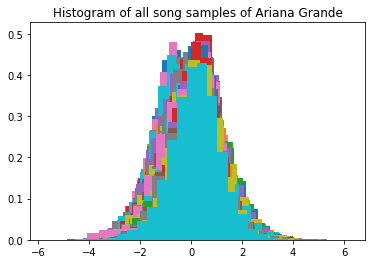

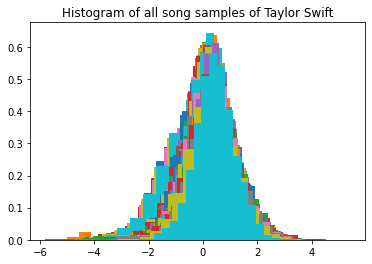

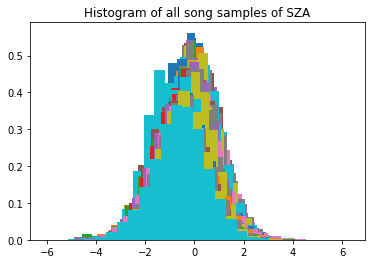

In [8]:
def plotHistogram(feature_data, y):
    singers = [feature_data[np.where(y == 0)], feature_data[np.where(y == 1)], feature_data[np.where(y == 2)]]

    for i, singer in enumerate(singers):
        for x in singer:
            plt.hist(x, density = True, bins = 20)
        if i == 0:
            artist = "Ariana Grande"
        elif i == 1:
            artist = "Taylor Swift"
        else:
            artist = "SZA"
        plt.title("Histogram of all song samples of " + artist)
        plt.show()
plotHistogram(X_std_old, y_old)

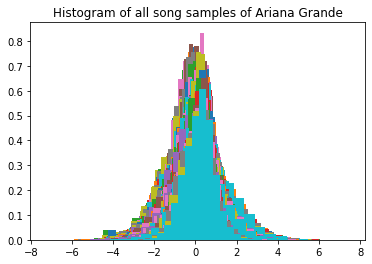

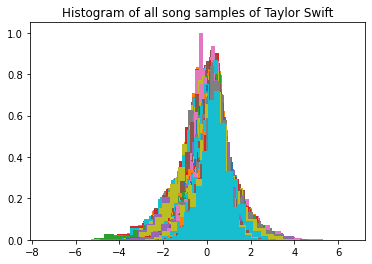

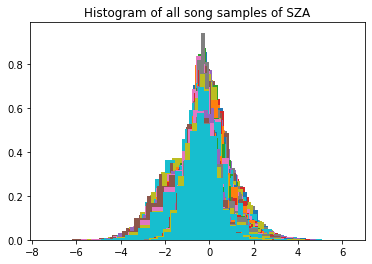

In [9]:
plotHistogram(X_std_new, y_new)

When all feature are brought to the same scale, differences between data about different artists start to rise. Taylor Swift's samples seem to have smaller range than the other 2 artists' and be quite normally distributed around 0 with greater density to the right. Meanwhile, SZA's song samples showcase more density to values to the left of 0, which implies that Taylor Swift's songs might have greater amplitude of sound in audio signals. Regarding Ariana Grande's songs, the density seems to be much lower than the other 2 artists' with only a few outliers having around 0.6 density around 0. We can infer that Ariana Grande's amplitude in sound is more spread out, rather focused on the middle point. 

**Final:** In general, the distribution over our data for each artist still inherits similar properties with our data in the previous pipeline. Here, Taylor Swift's music distribution is still the thinnest, which signifies how audio is centered around the middle part. Meanwhile, Ariana Grande's songs have much smaller density for the middle part, albeit still following a normal distribution. Ariana Grande is well-known for her high pitch, which explains some outliers to the range of 8 on the x-axis. For SZA, her music audio is pretty scattered, which explained a shorter normal distribution because density is shared over the range

## Task Discussion

The overall task here is clearly classification where we want to tell songs from different artists apart. Suppose we are given a new song, or machine speaking, a sequence of amplitude of sound, we should be able to predict whose artist this song is. 

Also, we need to note that our current data have too many features (25840), which mean a very high dimensional space. Therefore, I will use Principal Component Analysis to compress my data to lower-dimensional space for the sake of learning and computational efficiency. 

### PCA

PCA is a method of compressing data to low dimensional space, yet still preserves characteristics of our observations. By that, we mean PCA tries to maximize how data points differ from each other to not lose many properties in the original data. Given data about 25840 features, we can construct covariance matrix to verify how much different features vary from each other. From this covariance matrix, we can compute eigenvectors and eigenvalues. We know in algebra that, eigenvectors are those who stay the same after matrix transformation. Here, it works similarly! We are interested in eigenvectors because they point to the direction with greatest variances, so that if we project every data point vector on that eigenvector, we can still preserve variations to the greatest possible. Eigenvalues refer to how much our eigenvectors are scaled after matrix transformation, so here it means how much variance our direction of eigenvector can explain after projections.

Imagine that before PCA, we have a coordinate system with real standardized data and the origin is at all 0 coordinate. After PCA, our eigenvectors become the new axis in the new coordinate system and we project our data on new axes. As a result, we maintain variations in data, yet compress them to only a certain number of axes in the new coordinate system.

Below, I plotted a line between the number of principal components we use, aka the number of eigenvectors for axes in our new coorindate system VS the proportion of variance explained after this transformation. Note that the line should be monotonic because the more axes we use in our coordinate system, the more variance we are preserving in our original data.

I set a threshold of 85% variance explained to balance between low dimensionality and variance explained. Here, with 186 principal components, we can explain 85% variance explained. Note that our dimensions reduce from 25840 to 186 (a very dramatic decrease!) and still preserve 85% variance in data.

The number of principal components required to achieve 85% variance explained after PCA:  186


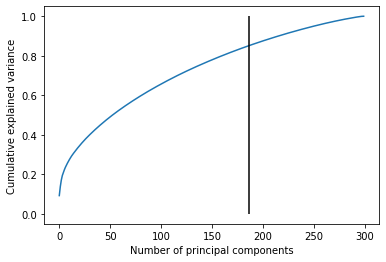

In [10]:
pca_old = PCA()
X_pca_old = pca_old.fit_transform(X_std_old)
variances_old = np.cumsum(pca_old.explained_variance_ratio_)
components_old = np.searchsorted(variances_old, 0.85)
plt.plot(variances_old)
plt.vlines(components_old, 0, 1, colors='black')
print("The number of principal components required to achieve 85% variance explained after PCA: ",components_old)
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.show()

**Final:** My new dataset now has too many data points (1800), which makes finding the eigenvectors to explain much variance more challenging. As a result, with multiple attempts, if I want to explain 80 or 85% of variance, the number of features will still be at around 600-700, which is quite a lot and requires much more computational resource for the model to complete training. Therefore, I decided to sacrifice some variance in original data and prioritize computational runtime to experiment with the model. I kept it at 70% variance explained and the number of components now is 333 which is a very good number. From 25840 features to only 333 and we can still maintain 70% of original data's properties.

The number of principal components required to achieve 70% variance explained after PCA:  333


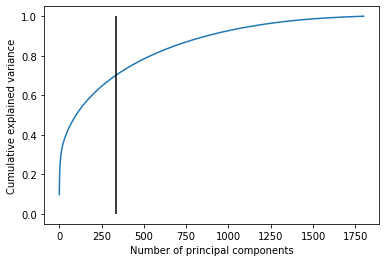

In [11]:
pca_new = PCA()
X_pca_new = pca_new.fit_transform(X_std_new)
variances_new = np.cumsum(pca_new.explained_variance_ratio_)
components_new = np.searchsorted(variances_new, 0.7)
plt.plot(variances_new)
plt.vlines(components_new, 0, 1, colors='black')
print("The number of principal components required to achieve 70% variance explained after PCA: ",components_new)
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative explained variance')
plt.show()

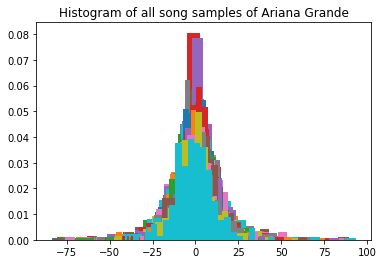

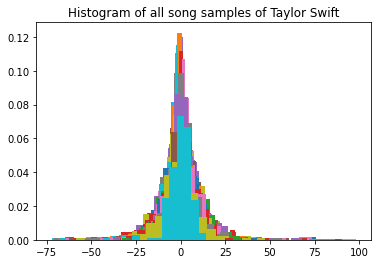

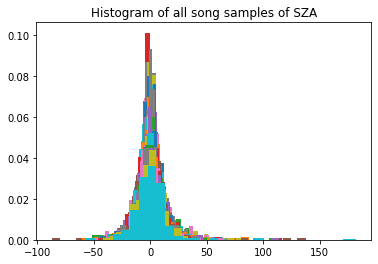

In [12]:
pca_old = PCA(n_components=components_old)
X_pca_old = pca_old.fit_transform(X_std_old)
plotHistogram(X_pca_old, y_old)

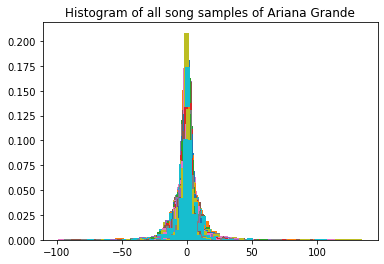

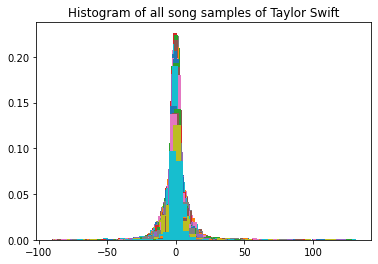

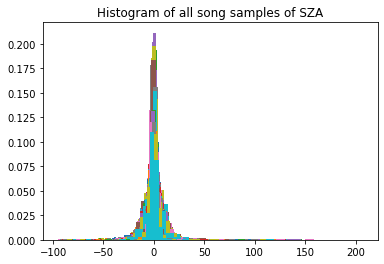

In [13]:
pca_new = PCA(n_components=components_new)
X_pca_new = pca_new.fit_transform(X_std_new)
plotHistogram(X_pca_new, y_new)

Yes! Our observations in Exploratory Data Analysis are even more visible now. Ariana Grande's music is indeed less focused on middle amplitude, yet more spread out, so the density is much lower. Taylor Swift's distribution does have greater density to the side of 0, yet in general very thin in the center - amplitude is very stable in the middle oftentimes. For SZA, surprisingly, the distribution entails more density to the right, which makes the range strikingly different from the other two artists.

**Final:** Pretty much similar to the old data, after compression, our distributions are more visible to see with some consistent changes. To elaborate, SZA music now has a wider range, which means more outlier. Taylor Swift music still has very thin normal distribution (aka very thin tail). Meanwhile, Ariana Grande's music becomes more spread out with shorter normal distribution.

In [14]:
X_train_old, X_test_old, y_train_old, y_test_old = train_test_split(X_pca_old, y_old, test_size = 0.3, random_state = 42)
normalizer_old = StandardScaler()
X_train_std_old = normalizer_old.fit_transform(X_train_old)
X_test_std_old = normalizer_old.transform(X_test_old)

In [15]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_pca_new, y_new, test_size = 0.3, random_state = 42)
normalizer_new = StandardScaler()
X_train_std_new = normalizer_new.fit_transform(X_train_new)
X_test_std_new = normalizer_new.transform(X_test_new)

Here, I split the data into training set and test set with test size of 0.3 out of the dataset size. I also normalize training feature data and standardize testing feature data to the same scale for the sake of computational efficiency for the model.

## Model Selection

To deal with classifying music of different artists, I am interested in building a Support Vector Machine classifier since this is the most recent model I have learned. It has a very well-constructed architecture of the learning algorithm with powerful flexibility of different kernel functions to separate data in high dimensional space. Therefore, I am just generally curious how it performs on my data. Also, a new model not covered in the class is k-Nearest Neighbors Classifier, which mainly computes the distance in high dimensional space, picks k closest data points with the one we're interested in, and then makes a decision of label based on the major labels of k-closest data points. I have never worked with this classifier before. It sounds much more simple and intuitive than SVM classifer, so I am curious if it can still achieve the same efficiency.

**Final:** For my final pipeline, I received a suggestion from my previous assignment feedback that XGBoost and Recurrent Neural Network tend to be really good at this job. Since both models have already been covered in class, I aim to try applying LightGBM here which is a variant of gradient boosting tree-based model. It is slightly different from XGBoost, with further explanations later. Yet, it seems powerful in classification tasks and I am excited to try it out with my data, or how it will perform compared to Support Vector Machines with kernels!

### Support Vector Machines Classifier

The whole point of Support Vector Machines Classifier is to construct a mathematical decision boundary which maximizes the distance between itself and the closest data point of each label. We assign a unique w_i parameter to the i-th feature. The linear combination of w_i * x_i will construct a line or generally, a hyperplane in the multi-dimensional space, which represents the boundaries between categories. Our optimization function here is 1/2 * ||w||^2, which is basically to minimize the length of vector w which incorporates all elements of weights here. With this optimization problem, we can find the convex or the value of w that reaches the maximum point of the function - greatest distance between the decision boundary and the support vectors - the closest data points of each label to the boundary.

Note that regularization terms jump in here to simplify our decision boundary and sacrifice some misclassification, rather than making the hyperplane more complicated to separate all labels to one side. In linear combination, the regularization term is just basically added.

#### Kernel

However, our data most of the time not linearly separable, which requires something more complicated than a linear combination. That's how a kernel jumps in. A kernel function will transform our data to a different domain, for example a higher-dimensional space where their characteristics have more variations, which helps the decision boundary more visible and efficient to construct.

There are so many different kernels, namely radial basis function, polynomial function or sigmoid function. I will go deeper into radial basis function because this is the kernel I am using for my model.

Radial basis function introduce non-linearities to our decision boundaries by mapping all of our data to another higher-dimensional space, which helps make data points further away from each other. 

The radial basis kernel computes how similar two input data points are through the formula
$K(x_i, x_j)$ = e <sup>$(-Gamma ||x_i - x_j|| ^ 2)$</sup>

Gamma will be a hyperparameter to control the width of the decision boundary here. 

### k-Nearest Neighbors Classifier

k-Nearest Neighbors Classifer is a simple model which uses Minkowski distance or Euclidean distance methods to find k nearests observations with our point of interest. Given the labels of k nearest observations, we will make a decision of label for our point of interest.

Here's a pseudocode in how the classifer makes a prediction:
1. Given a new data point we are interested in classifying, we will compare it will all other data points in the training set
2. This is how we compute distance between the new data point and every other training data point
    a. We can use Euclidean distance formula, which treats all data points as single vector with the number of components equal to the number of features. The formula is $$ sqrt(∑ᵢ(Xᵢ - Yᵢ)²) $$
    b. We can also use Mankowski distance formula with the same inner workings. The difference is instead of taking them sum of squares of the difference, we take the distance here to the power of the number of features and take the p-th root out of the sum. The formula is ( ∑ᵢ|Xᵢ - Yᵢ|ᵖ ) <sup> (1/p) </sup> 
    
3. After computing all distances between the point of interest and all other training points, we will choose k points with smallest distances

4. Given labels of these k points, the majority will become our prediction

### LightGBM

LightGBM is an extension to tree-based classification model because it involves gradient boosting strategy, which is a special type of ensemble learning. Generally, LightGBM involves multiple weak learners (small trees), yet knows how to combine all of them to gain most information about the data possible. Each weak learner also learns from the mistake of the previous one, which makes the algorithm achieve time-efficiency and correctness at the same time. Gradient here jumps in when the algorithm in general greedily looks for the best next split to optimize on classification accuracy, which involves learning rate to control for overfitting and optimization as well. The algorithm also has a lot of regularization terms to prevent the model from learning too much about the data.

LightGBM shares some differences from XGBoost, which makes it a faster algorithm

1. It scales the tree vertically while XGBoost grows the tree horizontally. Recall that XGBoost has multiple small trees, yet each only has 2 or 3 levels. Then, the algorithm uses gradient boosting to gain most information with equally short trees together. However, LightGBM expands leaves to open further branches to gain the most information. So it is basically expanding leaves and making the trees taller. Therefore, one way to prevent overfitting in LightGBM is the parameter maximum depth of trees

2. XGBoost employs second-order approximation to compute the gradients meanwhile LightGBM uses a histogram-based approach which focuses on samples with higher density, thus assigning stronger gradients to them, and forgets less important ones. This approach is called Gradient-based One-side Sampling. This approach provides a shortcut for the model to quickly learn from the data effectively

3. LightGBM also uses Exclusive Feature Bundling which basically identifies correlated features in data and only combines unique features to reduce dimensionality ("bundles features together". This algorithm allows the model to quickly deal with large high-dimensional datasets, and still efficiently tell differences between then

We also should cover some mathematical behind how LightGBM determines what is the next best split, or how to compute information gain basically

$Gain = \frac{1}{2} \bigg[\frac{\sum_{i \in I_L}g_i}{\sum_{i \in I_L}h_i + \lambda} + \frac{\sum_{i \in I_R}g_i}{\sum_{i \in I_R}h_i + \lambda} - \frac{\sum_{i \in I}g_i}{\sum_{i \in I}h_i + \lambda} \bigg] - \gamma$

This function basically computes the score for proposed splits for the left and child nodes, sum them together and subtract the score of the parents to achieve the gain. G and H refers to Gradient and Hessian function to approximate how we should make the next move. In addition, lambda and gamma refer to hyperparameters to control for regularization 

## Model Training and Parameter Tuning with Cross Validation

As mentioned before, Support Vector Machines have many parameters, whether it is what kernel function to use, what kernel coefficient for some types of kernel function, what intercept in kernel function, or how much regularization we should parameterize. Similarly for k-Nearest Neighbors, we also have to choose the optimal k - the number of nearest neighbors.

Therefore, I will list all possible combinations of parameters for each model, perform cross validations and use grid-search to find the most optimal set of parameters to initialize the model and train it. 

Cross validation is basically when we randomly divide the training data into k folds, train on the k - 1 folds and test on the only fold left. We repeat the process k times and average our validation accuracy. This process just basically gives more exposure to our model, thus giving a more objective evaluation. Here, I use the default value of 5 folds.

Grid Search basically lists all possible combinations of parameter we are tuning, keep track of model performance with each possible combination and pick the one with best performance.

**Final:** LightGBM also has a lot of parameters to add flexibility to the model about the number of leaves or learning rate for gradient boosting strategy as well as the maximum depth of the tree to control for overfitting. Therefore, cross-validation for parameter tuning is also crucial  here. However, with a large dataset and exhaustive computational resource, I only include 4 parameters in the parameter tuning with cross validation process: number of leaves, learning rate, maximum depth, and number of estimators.

In [16]:
# the code was adapted from this notebook: https://www.kaggle.com/code/pranathichunduru/svm-for-multiclass-classification
classes = ['Ariana Grande', 'Taylor Swift', 'SZA']
svm_params_grid = [
    {'kernel': ['rbf'], 'gamma': ['scale', 1e-3, 1e-4], 'C': [1, 10, 100, 1000]}, 
    {'kernel': ['sigmoid'], 'gamma' : ['scale', 1e-3, 1e-4], 'coef0' : [-1, 0, 1], 'C': [1, 10, 100, 1000]}]
svm_old = GridSearchCV(SVC(), svm_params_grid, cv=5)
svm_old.fit(X_train_std_old, y_train_old)
print("SVM Parameter Tuning Results")
print("\n")
print('Best C:',svm_old.best_estimator_.C,"\n") 
print('Best Kernel:',svm_old.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_old.best_estimator_.gamma,"\n")
print('Best Intercept:',svm_old.best_estimator_.coef0,"\n")

SVM Parameter Tuning Results


Best C: 100 

Best Kernel: rbf 

Best Gamma: 0.001 

Best Intercept: 0.0 



In [17]:
svm_new = GridSearchCV(SVC(), svm_params_grid, cv=5)
svm_new.fit(X_train_std_new, y_train_new)
print("SVM Parameter Tuning Results")
print("\n")
print('Best C:',svm_new.best_estimator_.C,"\n") 
print('Best Kernel:',svm_new.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_new.best_estimator_.gamma,"\n")
print('Best Intercept:',svm_new.best_estimator_.coef0,"\n")

SVM Parameter Tuning Results


Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.001 

Best Intercept: 0.0 



In [18]:
knn_params_grid = {'n_neighbors' : [i for i in range(1, int(len(X_train_old) ** 0.5), 2)]}
knn_old = GridSearchCV(KNeighborsClassifier(), knn_params_grid, cv=5)
knn_old.fit(X_train_std_old, y_train_old)
print("KNN Parameter Tuning Results")
print("\n")
print('Best number of neighbors:', knn_old.best_params_, "\n")

KNN Parameter Tuning Results


Best number of neighbors: {'n_neighbors': 7} 



In [19]:
knn_params_grid = {'n_neighbors' : [i for i in range(1, int(len(X_train_new) ** 0.5), 2)]}
knn_new = GridSearchCV(KNeighborsClassifier(), knn_params_grid, cv=5)
knn_new.fit(X_train_std_new, y_train_new)
print("KNN Parameter Tuning Results")
print("\n")
print('Best number of neighbors:', knn_new.best_params_, "\n")

KNN Parameter Tuning Results


Best number of neighbors: {'n_neighbors': 1} 



In [20]:
# this code takes a while to run
params = {
    'num_leaves': [10, 20, 30],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50, 100, 150]
}
lgbm = GridSearchCV(lgb.LGBMClassifier(), param_grid=params, cv=5, scoring='accuracy')
lgbm.fit(X_train_std_new, y_train_new)
print("Best parameters:", lgbm.best_params_)
print("Best score:", lgbm.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'num_leaves': 10}
Best score: 0.8920634920634921


Now we will use SVM, KNN and LightGBM models with the identified optimal set of parameters to make predictions. We'll see how well the best training model performs in testing data or how subjective it is to overfitting.

## Model Testing and Performance Metrics with Visualizations

Looking at the result, both models achieve a training accuracy of 1, which signals some sort of overfitting here. For Support Vector Machine, the complexity of learning algorithm might be a cool advantage to really draw decision boundary between different labels. However, note that here we choose the optimal set of parameter in the tuning process. Therefore, the regularization parameter might not be actually the best one to use in testing data, which we need to be careful of

For k-Nearerst Neighbor Classifier, the training process is only to find the best number of nearest neighbors for the prediction process. So it will always be 1 because we have not really trained any formula here. The inner working here lies the most on how a new data is compared with other data in terms of distance, so prediction process is what we should care more

Overall, the KNN performs kinda bad in the test set, with only 0.467 accuracy score. The SVM is much better - 0.65, but still not that good. Therefore, overfitting really exists here and we need more work in the parameter tuning process!

Here, I chose precision, recall and f1-score as the main metrics for this pipeline. Precision refers to proportion of positive predictions being correct. In other words, it's like the proportion of actually correct Ariana Grande songs out of all Ariana Grande predictions. Recall is more about the number of positives correctly identified. Intuitively, out of all Ariana Grande songs in the test set, how many are correctly classified. For F-1 score, it basically combines the two metrics above with the formula of $${{2 * (Precision * Recall)}\over(Precision + Recall)}$$

I would say F-1 score is a quick and good metric to look at now to generally understand how well labels are recognized by the model. But to dig deeper into what's going on, precision and recall will be more informative.

               precision    recall  f1-score   support

Ariana Grande       0.62      0.85      0.72        27
 Taylor Swift       0.85      0.63      0.72        35
          SZA       0.70      0.68      0.69        28

     accuracy                           0.71        90
    macro avg       0.72      0.72      0.71        90
 weighted avg       0.73      0.71      0.71        90

Training set score for SVM: 1.000000
Testing  set score for SVM: 0.711111


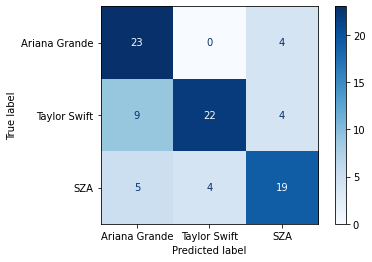

In [21]:
final_svm_old = svm_old.best_estimator_
y_pred_svm_old = final_svm_old.fit(X_train_std_old, y_train_old).predict(X_test_std_old)
display_svm_old = ConfusionMatrixDisplay(confusion_matrix(y_test_old,y_pred_svm_old), display_labels = classes)
display_svm_old.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
print(classification_report(y_test_old,y_pred_svm_old, target_names=classes))

print("Training set score for SVM: %f" % final_svm_old.score(X_train_std_old, y_train_old))
print("Testing  set score for SVM: %f" % final_svm_old.score(X_test_std_old, y_test_old))

               precision    recall  f1-score   support

Ariana Grande       0.79      0.76      0.77       188
 Taylor Swift       0.83      0.82      0.82       184
          SZA       0.73      0.77      0.75       168

     accuracy                           0.78       540
    macro avg       0.78      0.78      0.78       540
 weighted avg       0.78      0.78      0.78       540

Training set score for SVM: 0.970635
Testing  set score for SVM: 0.781481


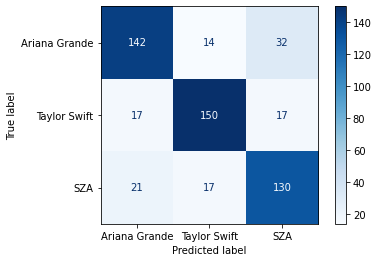

In [22]:
final_svm_new = svm_new.best_estimator_
y_pred_svm_new = final_svm_new.fit(X_train_std_new, y_train_new).predict(X_test_std_new)
display_svm_new = ConfusionMatrixDisplay(confusion_matrix(y_test_new,y_pred_svm_new), display_labels = classes)
display_svm_new.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
print(classification_report(y_test_new,y_pred_svm_new, target_names=classes))

print("Training set score for SVM: %f" % final_svm_new.score(X_train_std_new, y_train_new))
print("Testing  set score for SVM: %f" % final_svm_new.score(X_test_std_new, y_test_new))

**Final:** Data augmentation really helps fix overfitting in Support Vector Machines! Training set score in the previous pipeline is 1, now reduced to 0.97 in this pipeline, which is still a good estimate! Meanwhile, the testing set score, which is more important, increased from 0.71 to 0.78. This proves that with larger dataset, the model is less subject to overfitting. Support Vector Machines now also have strictly better F-1 scores in all labels than the previous assignment.

               precision    recall  f1-score   support

Ariana Grande       1.00      0.04      0.07        27
 Taylor Swift       0.46      0.94      0.62        35
          SZA       0.65      0.39      0.49        28

     accuracy                           0.50        90
    macro avg       0.70      0.46      0.39        90
 weighted avg       0.68      0.50      0.41        90

Training set score for KNN: 1.000000
Testing  set score for KNN: 0.500000


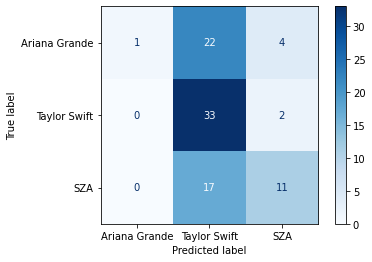

In [23]:
final_knn_old = KNeighborsClassifier(n_neighbors = 1)
y_pred_knn_old = final_knn_old.fit(X_train_std_old, y_train_old).predict(X_test_std_old)
display_knn_old = ConfusionMatrixDisplay(confusion_matrix(y_test_old,y_pred_knn_old), display_labels = classes)
display_knn_old.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
print(classification_report(y_test_old,y_pred_knn_old, target_names=classes))

print("Training set score for KNN: %f" % final_knn_old.score(X_train_std_old, y_train_old))
print("Testing  set score for KNN: %f" % final_knn_old.score(X_test_std_old, y_test_old))

               precision    recall  f1-score   support

Ariana Grande       0.84      0.22      0.35       188
 Taylor Swift       0.43      0.97      0.60       184
          SZA       0.65      0.29      0.40       168

     accuracy                           0.50       540
    macro avg       0.64      0.49      0.45       540
 weighted avg       0.64      0.50      0.45       540

Training set score for KNN: 1.000000
Testing  set score for KNN: 0.498148


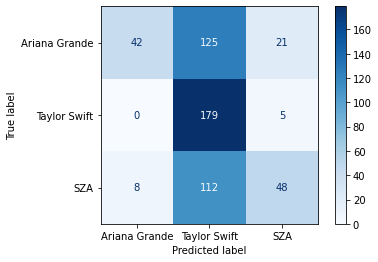

In [24]:
final_knn_new = KNeighborsClassifier(n_neighbors = 1)
y_pred_knn_new = final_knn_new.fit(X_train_std_new, y_train_new).predict(X_test_std_new)
display_knn_new = ConfusionMatrixDisplay(confusion_matrix(y_test_new,y_pred_knn_new), display_labels = classes)
display_knn_new.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
print(classification_report(y_test_new,y_pred_knn_new, target_names=classes))

print("Training set score for KNN: %f" % final_knn_new.score(X_train_std_new, y_train_new))
print("Testing  set score for KNN: %f" % final_knn_new.score(X_test_std_new, y_test_new))

With a few runs, k-Nearest Neighbors model did not really perform differently with augmented dataset. It still struggles to find the correct neighbor to make predictions. Maybe I guess this model is not suited for this task or this dataset.

               precision    recall  f1-score   support

Ariana Grande       0.92      0.94      0.93       188
 Taylor Swift       0.94      0.93      0.94       184
          SZA       0.90      0.89      0.90       168

     accuracy                           0.92       540
    macro avg       0.92      0.92      0.92       540
 weighted avg       0.92      0.92      0.92       540

Training set score for LightGBM: 1.000000
Testing  set score for LightGBM: 0.922222


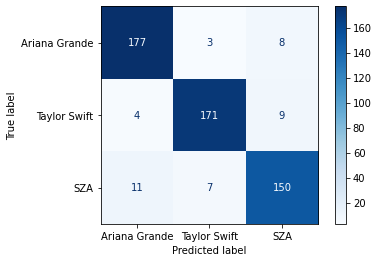

In [25]:
best_params = lgbm.best_params_
lgb_final = lgb.LGBMClassifier(**best_params)
lgb_final.fit(X_train_std_new, y_train_new)
y_pred_new = lgb_final.predict(X_test_std_new)

display_lgb = ConfusionMatrixDisplay(confusion_matrix(y_test_new,y_pred_new), display_labels = classes)
display_lgb.plot(include_values=True, cmap='Blues', ax=None, xticks_rotation='horizontal')
print(classification_report(y_test_new,y_pred_new, target_names=classes))

print("Training set score for LightGBM: %f" % lgb_final.score(X_train_std_new, y_train_new))
print("Testing  set score for LightGBM: %f" % lgb_final.score(X_test_std_new, y_test_new))

Yay! This is our best model so far. LightGBM achieves the best possible training set score, and still achieves 0.92 testing set score. This means the model learns well from the data and knows how to use information to make predictions for unseen data. 0.92 testing set score is also a very good estimate even though we can make it higher than 0.95 thanks to better cross-validation. However, it still confirms that LightGBM model is not highly subject to overfitting and performs well in this data and this classification task.

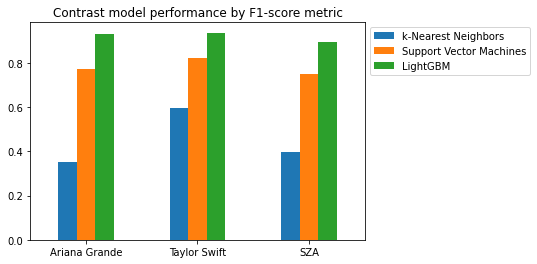

In [26]:
import pandas as pd
# adapted from this code https://stackoverflow.com/questions/38810009/matplotlib-plot-bar-and-line-charts-together
svm = classification_report(y_test_new,y_pred_svm_new, target_names=classes, output_dict = True)
knn = classification_report(y_test_new,y_pred_knn_new, target_names=classes, output_dict = True)
lgbm = classification_report(y_test_new,y_pred_new, target_names=classes, output_dict = True)

results = pd.DataFrame({
    'Support Vector Machines' : [svm['Ariana Grande']['f1-score'], svm['Taylor Swift']['f1-score'], svm['SZA']['f1-score']],
    'k-Nearest Neighbors' : [knn['Ariana Grande']['f1-score'], knn['Taylor Swift']['f1-score'], knn['SZA']['f1-score']],
    'LightGBM' : [lgbm['Ariana Grande']['f1-score'], lgbm['Taylor Swift']['f1-score'], lgbm['SZA']['f1-score']]
})
width = 0.5
results[['k-Nearest Neighbors', 'Support Vector Machines','LightGBM']].plot(kind='bar', width = width)
ax = plt.gca()
ax.set_xticklabels(('Ariana Grande', 'Taylor Swift', 'SZA'), rotation = 0)
ax.legend(bbox_to_anchor=(1, 1))
plt.title("Contrast model performance by F1-score metric")
plt.show()

I chose F1-score as a harmonic metric to judge models' performance overall. From the plot, we can see that LightGBM can perform strictly better than all other models for recognizing all artists' music. This is such an improvement compared to the previous assignment!

## Reflections and Possible Extensions

**Final:**
This new pipeline adds more data augmentation and introduces a new powerful method - LightGBM. Some key insights:

1. Data augmentation helps achieve a 6 times larger dataset size, which reduces overfitting, as evidenced in the case of Support Vector Machines

2. LightGBM is really good at classification tasks, especially here audio classification. It achieves training set score of 1 and testing set score of 0.89 while our compressed data can only explain 70% variance of our original data.

There are many things to improve with this pipeline:

1. Computational Resource: Due to constraint of computational resource, I accepted more loss in data compression for the sake of computational runtime to train the model. I also reduced the volume of cross-validation for parameter tuning because LightGBM has a lot of parameters to tune. With stronger computer and more knowledge about tricks to improve code or any efficient packages, I believe the result can be even more convincing

2. Human Voice: Since we are analyzing songs from different artists, we also should include aspects of human speech or singers' voice to make classification easier. With human ears, I am pretty sure Ari, Taylor and SZA have very different songs and voices. Therefore, this model can also be improved more with more advanced techniques in recognizing and analyzing human voice